In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from datetime import datetime
import networkx as nx

# Add parent directory to path to import local modules
sys.path.insert(0, str(Path.cwd().parent))

from src.behavior_import.import_data import *
from src.behavior_import.extract_trials import *
from src.behavior_analysis.get_reversal_info import *
from src.behavior_visualization.plot_num_reversals import *

In [2]:
import matplotlib as mpl

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Helvetica Neue", "Helvetica", "Arial"]

In [3]:
root = "../data/cohort-02/rawdata/"
subjects_data = import_data(root)

[INFO] Processed 6 subjects(s), 90 session(s).


In [4]:
subjects_trials = extract_trials(subjects_data)

[INFO] Merging multiple files for subject MY_05_L, session ses-8_date-20260114
[INFO] Merging multiple files for subject MY_05_L, session ses-9_date-20260115
[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[INFO] Merging multiple files for subject MY_05_N, session ses-2_date-20260111


In [35]:
reversal_windows = get_reversal_info(subjects_trials, pre=5, post=30)

[WARNING] No trial information found for subject MY_05_N, session ses-1_date-20260111
[SKIP] MY_05_L reversal@401 (block 8): reward magnitudes before reversal were [4, 0, 0] across towers ['A3', 'A1', 'C3'] (expected a permutation of [4, 1, 0])


In [ ]:
def filter_reversal_windows_by_subject(reversal_windows, subjects_to_keep):
    subjects_to_keep = set(subjects_to_keep)
    return {
        subj: revs
        for subj, revs in reversal_windows.items()
        if subj in subjects_to_keep
    }

reversal_windows = filter_reversal_windows_by_subject(
    reversal_windows,
    ["MY_04_N", "MY_04_L", "MY_05_L"]
)

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def _classify_towers_from_rewards(reversal):
    """
    Determine:
      - prev_best: best tower BEFORE reversal (max reward before)
      - next_best: best tower AFTER reversal  (max reward after)
      - third: the remaining tower
    Assumes 3 towers.
    """
    before = reversal["reward_magnitudes_by_tower_before"]
    after  = reversal["reward_magnitudes_by_tower_after"]

    prev_best = max(before, key=before.get)
    next_best = max(after,  key=after.get)

    towers = set(before.keys())
    third = list(towers - {prev_best, next_best})[0]
    return prev_best, next_best, third


def _concat_pre_post(reversal, tower):
    """Concatenate pre + post choice arrays for a given tower."""
    return reversal["choices_by_tower"][tower]["pre"] + reversal["choices_by_tower"][tower]["post"]


def aggregate_reversal_probs_by_subject(reversal_windows, pre=5, post=15):
    """
    Returns:
      x: np.array of relative trial indices, length pre+post ([-pre ... post-1])
      per_subject: dict[subj] -> dict with keys:
        - "prev_best": np.array
        - "next_best": np.array
        - "third": np.array
        - "n_reversals": int
      across: dict with keys:
        - "mean": dict[label]->np.array
        - "std":  dict[label]->np.array
        - "n_subjects": int
    """

    T = pre + post
    x = np.arange(-pre, post)

    per_subject = {}

    for subj, revs in reversal_windows.items():
        if not revs:
            continue

        # Collect aligned traces for each reversal (shape: n_reversals x T)
        prev_mat = []
        next_mat = []
        third_mat = []

        for r in revs:
            prev_best, next_best, third = _classify_towers_from_rewards(r)

            prev_arr  = _concat_pre_post(r, prev_best)
            next_arr  = _concat_pre_post(r, next_best)
            third_arr = _concat_pre_post(r, third)

            # Defensive: skip if not expected length
            if not (len(prev_arr) == len(next_arr) == len(third_arr) == T):
                # If your windows are sometimes clipped at edges, you can pad with np.nan instead.
                continue

            prev_mat.append(prev_arr)
            next_mat.append(next_arr)
            third_mat.append(third_arr)

        if len(prev_mat) == 0:
            continue

        prev_mat  = np.array(prev_mat, dtype=float)
        next_mat  = np.array(next_mat, dtype=float)
        third_mat = np.array(third_mat, dtype=float)

        # Subject-level mean across reversals
        per_subject[subj] = {
            "prev_best": prev_mat.mean(axis=0),
            "next_best": next_mat.mean(axis=0),
            "third": third_mat.mean(axis=0),
            "n_reversals": prev_mat.shape[0],
        }

    # --- Across-subject mean + std (std across subjects, not reversals) ---
    labels = ["prev_best", "next_best", "third"]
    subj_list = list(per_subject.keys())
    n_subjects = len(subj_list)

    if n_subjects == 0:
        across = {"mean": {k: None for k in labels}, "std": {k: None for k in labels}, "n_subjects": 0}
        return x, per_subject, across

    across_mean = {}
    across_std = {}

    for k in labels:
        stack = np.vstack([per_subject[subj][k] for subj in subj_list])  # (n_subjects, T)
        across_mean[k] = stack.mean(axis=0)
        across_std[k]  = stack.std(axis=0, ddof=1) if n_subjects > 1 else np.zeros(T)

    across = {"mean": across_mean, "std": across_std, "n_subjects": n_subjects}
    return x, per_subject, across


def plot_reversal_probs_across_subjects(x, across, show_chance=True):
    """
    Plots across-subject mean with +/- 1 std fill.
    """
    mean = across["mean"]
    std = across["std"]

    fig, ax = plt.subplots(figsize=(8, 4.5))

    for label, nice in [
        ("prev_best", "Previous Best"),
        ("next_best", "New Best"),
        ("third", "Third Arm"),
    ]:
        y = mean[label]
        s = std[label]
        ax.plot(x, y, label=nice, linewidth=2)
        ax.fill_between(x, y - s, y + s, alpha=0.2)

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    if show_chance:
        ax.axhline(1/3, color="gray", linestyle=":", linewidth=1)

    ax.set_xlabel("Trials from Good Reversal")
    ax.set_ylabel("Choice Probability")
    ax.set_title(f"Good Reversal-Aligned Choices (mean ± SD across subjects, n={across['n_subjects']})")

    ax.legend()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(x[0], x[-1])
    plt.tight_layout()
    plt.show()

    return fig, ax

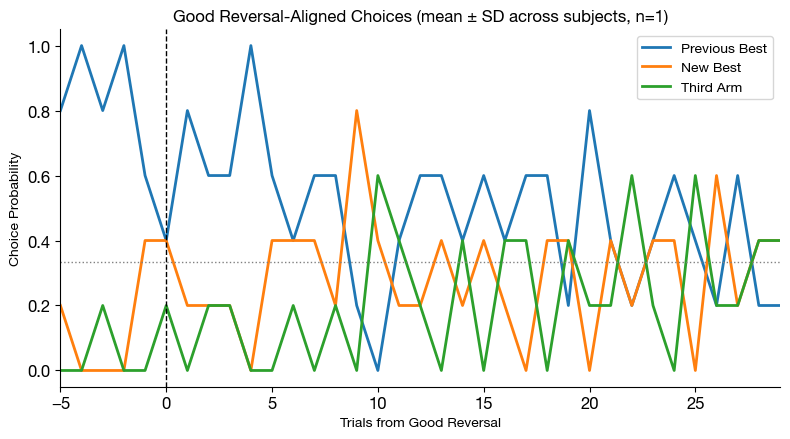

(<Figure size 800x450 with 1 Axes>,
 <Axes: title={'center': 'Good Reversal-Aligned Choices (mean ± SD across subjects, n=1)'}, xlabel='Trials from Good Reversal', ylabel='Choice Probability'>)

In [43]:
# reversal_windows = get_reversal_choices(merged_data, pre=5, post=15, ...)

x, per_subject, across = aggregate_reversal_probs_by_subject(reversal_windows, pre=5, post=30)

# per_subject is your dictionary of subject-level mean traces
# across has mean/std across subjects
plot_reversal_probs_across_subjects(x, across)


In [37]:
import numpy as np
import matplotlib.pyplot as plt

def _classify_towers_from_rewards(reversal):
    before = reversal["reward_magnitudes_by_tower_before"]
    after  = reversal["reward_magnitudes_by_tower_after"]

    prev_best = max(before, key=before.get)
    new_best  = max(after,  key=after.get)

    towers = set(before.keys())
    third = list(towers - {prev_best, new_best})[0]
    return prev_best, new_best, third

def _chosen_tower_from_onehots(reversal, trial_idx, towers):
    """
    Given a trial index into the concatenated window and towers,
    infer which tower was chosen using one-hot arrays in choices_by_tower.
    Returns tower name or None if cannot infer.
    """
    vals = []
    for t in towers:
        # choices_by_tower[t] has "pre" and "post" lists; we'll pass trial_idx relative to post only below
        vals.append(reversal["choices_by_tower"][t]["post"][trial_idx])
    # Expect exactly one 1; fall back to argmax
    if all(v is None for v in vals):
        return None
    j = int(np.nanargmax(np.asarray(vals, dtype=float)))
    return towers[j]

def first_leave_choice_stats(reversal_windows):
    """
    Returns per_subject counts:
      per_subject[subj] = {
        "new_best": int,
        "third": int,
        "no_leave": int,
        "total": int
      }
    """
    per_subject = {}

    for subj, revs in reversal_windows.items():
        counts = {"new_best": 0, "third": 0, "no_leave": 0, "total": 0}

        for r in revs:
            prev_best, new_best, third = _classify_towers_from_rewards(r)
            towers = [prev_best, new_best, third]  # fixed ordering for inference

            post_len = len(r["choices_by_tower"][prev_best]["post"])

            first_non_prev = None
            for j in range(post_len):
                chosen = _chosen_tower_from_onehots(r, j, towers)
                if chosen is None:
                    continue
                if chosen != prev_best:
                    first_non_prev = chosen
                    break

            counts["total"] += 1
            if first_non_prev is None:
                counts["no_leave"] += 1
            elif first_non_prev == new_best:
                counts["new_best"] += 1
            elif first_non_prev == third:
                counts["third"] += 1
            else:
                # Shouldn't happen with 3 towers, but keep it safe
                counts["no_leave"] += 1

        per_subject[subj] = counts

    return per_subject

def plot_first_leave_choice_bar(per_subject_counts, include_no_leave=False):
    """
    Grouped bar plot per subject: fraction of reversals where first leave goes to new_best vs third.
    If include_no_leave=True, plot a third bar for no_leave.
    """
    subjects = sorted(per_subject_counts.keys())
    x = np.arange(len(subjects))
    width = 0.35

    new_frac = []
    third_frac = []
    no_leave_frac = []

    for s in subjects:
        c = per_subject_counts[s]
        denom = c["total"] if c["total"] > 0 else 1
        new_frac.append(c["new_best"] / denom)
        third_frac.append(c["third"] / denom)
        no_leave_frac.append(c["no_leave"] / denom)

    fig, ax = plt.subplots(figsize=(10, 4.5))

    if include_no_leave:
        width = 0.25
        ax.bar(x - width, new_frac, width=width, label="First leave → New best", edgecolor="black", alpha=0.8)
        ax.bar(x,         third_frac, width=width, label="First leave → Third arm", edgecolor="black", alpha=0.8)
        ax.bar(x + width, no_leave_frac, width=width, label="No leave in post window", edgecolor="black", alpha=0.8)
    else:
        ax.bar(x - width/2, new_frac, width=width, label="First leave → New best", edgecolor="black", alpha=0.8)
        ax.bar(x + width/2, third_frac, width=width, label="First leave → Third arm", edgecolor="black", alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(subjects, rotation=45, ha="right")
    ax.set_ylabel("Fraction of good reversals")
    ax.set_title("First choice after leaving previous best")
    ax.legend()

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

    return fig, ax


/var/folders/g7/dhg2tq9173j2cwmlq6jvq28r0000gn/T/ipykernel_87346/1295082919.py:115: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  plt.tight_layout()
/Users/megyoung/anaconda3/envs/magnitude-bandit-analysis/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Helvetica Neue.
  fig.canvas.print_figure(bytes_io, **kw)


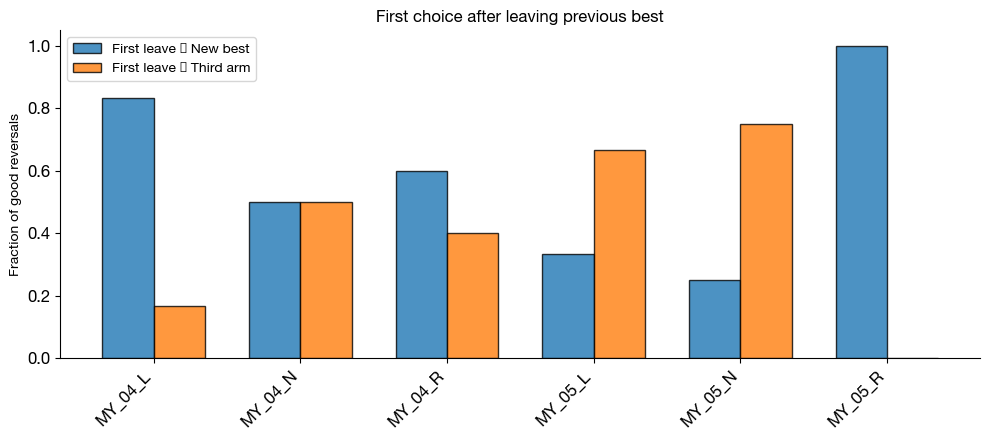

(<Figure size 1000x450 with 1 Axes>,
 <Axes: title={'center': 'First choice after leaving previous best'}, ylabel='Fraction of good reversals'>)

In [38]:
per_subj_counts = first_leave_choice_stats(reversal_windows)
plot_first_leave_choice_bar(per_subj_counts, include_no_leave=False)

# Optional: include "no leave" as a third bar
# plot_first_leave_choice_bar(per_subj_counts, include_no_leave=True)


In [39]:
import numpy as np

def average_first_leave_across_subjects(per_subject_counts, include_no_leave=False):
    """
    Returns:
      mean: dict[label] -> float
      std:  dict[label] -> float
      n_subjects: int
    """
    new_vals = []
    third_vals = []
    no_leave_vals = []

    for subj, c in per_subject_counts.items():
        if c["total"] == 0:
            continue

        new_vals.append(c["new_best"] / c["total"])
        third_vals.append(c["third"] / c["total"])
        no_leave_vals.append(c["no_leave"] / c["total"])

    mean = {
        "new_best": np.mean(new_vals),
        "third": np.mean(third_vals),
    }
    std = {
        "new_best": np.std(new_vals, ddof=1) if len(new_vals) > 1 else 0.0,
        "third": np.std(third_vals, ddof=1) if len(third_vals) > 1 else 0.0,
    }

    if include_no_leave:
        mean["no_leave"] = np.mean(no_leave_vals)
        std["no_leave"] = np.std(no_leave_vals, ddof=1) if len(no_leave_vals) > 1 else 0.0

    return mean, std, len(new_vals)


In [40]:
import matplotlib.pyplot as plt

def plot_avg_first_leave(mean, std, n_subjects, include_no_leave=False):
    labels = ["New best", "Third arm"]
    means = [mean["new_best"], mean["third"]]
    errs = [std["new_best"], std["third"]]

    if include_no_leave:
        labels.append("No leave")
        means.append(mean["no_leave"])
        errs.append(std["no_leave"])

    x = np.arange(len(labels))

    fig, ax = plt.subplots(figsize=(4.5, 4))

    ax.bar(
        x,
        means,
        yerr=errs,
        capsize=6,
        edgecolor="black",
        alpha=0.8
    )

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Fraction of good reversals")
    ax.set_title(f"First choice after leaving previous best\n(mean ± SD across subjects, n={n_subjects})")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

    return fig, ax


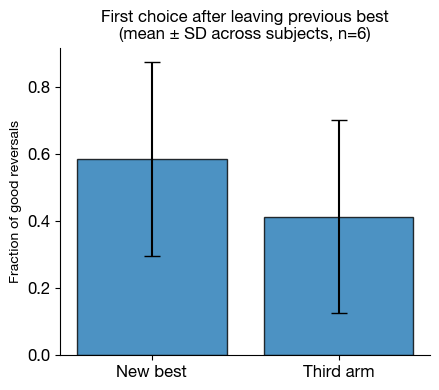

(<Figure size 450x400 with 1 Axes>,
 <Axes: title={'center': 'First choice after leaving previous best\n(mean ± SD across subjects, n=6)'}, ylabel='Fraction of good reversals'>)

In [41]:
per_subject_counts = first_leave_choice_stats(reversal_windows)

mean, std, n_subjects = average_first_leave_across_subjects(
    per_subject_counts,
    include_no_leave=False
)

plot_avg_first_leave(mean, std, n_subjects)
